# 3) Comparing classifiers 

author: Mat Gilson, https://github.com/MatthieuGilson

This notebook compares different classifiers for a synthetic dataset. It includes nested cross-validation to optimize hyperparameters.

See also the documentation of scikit-learn library (https://scikit-learn.org/)

In [1]:
# import librairies

import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb

font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 18}
mpl.rc('font', **font)

Let's generate a dataset for classification, including labels.

In [2]:
# create synthetic dataset where 2 classes of s0+s1 samples of m-dimensional inputs with controlled contrast
def gen_inputs(m,        # input dimensionality
               s0,       # number of samples for class 0
               s1,       # number of samples for class 1
               scaling): # scaling factor to separate classes

    # labels
    lbl = np.zeros([s0+s1], dtype=int)
    # inputs
    X = np.zeros([s0+s1,m])

    # create s0 and s1 samples for the 2 classes
    for i in range(s0+s1):
        # label
        lbl[i] = int(i<s0)
        # inputs are random noise plus a shift
        for j in range(m):
            # positive/negative shift for 1st/2nd class
            if i<s0:
                a = -scaling
            else:
                a = scaling
            # the shift linearly depends on the feature index j
            X[i,j] = a*j/m + np.random.randn()
            
    return X, lbl

In [3]:
# input properties
m = 10 # input dimensionality
s0 = 100 # number of samples for class 0
s1 = 100 # number of samples for class 1
scaling = 1.0 # class contrast (try 0.5, 0.1)

# generate inputs
X, y = gen_inputs(m, s0, s1, scaling)

## Comparison of classifiers

We want to compare the accuracy for different classifiers:
- MLR is the multinomial logistic regression
- 1NN is the 1-nearest-neighbor
- RF is a random forest
- QDA is a quadratic discrimnant analysis

In [4]:
# classifiers
clf_MLR = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500)

clf_1NN = KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='minkowski')

clf_RF = RandomForestClassifier(n_estimators=10)

clf_QDA = QuadraticDiscriminantAnalysis()

dict_clf = {'MLR': clf_MLR,
            '1NN': clf_1NN,
            'RF': clf_RF,
            'QDA': clf_QDA}

# dictionary of hyperparameters and ranges to explore (grid search)
dict_params = {'C': [0.01,0.1,1.0,10.0,100.0],               # C for regularization
               'n_neighbors': [1,2,3,4,5],                   # k nearest neighbors
               'criterion': ['gini', 'entropy'], # splitting quality eval
               'reg_param': [0.01,0.1,1.0]}       # regularization param

We use cross-validation with the evaluation of test accuracy, as well as nested cross-validation to optimize hyperparameters.

In [5]:
# outer cross-validation scheme: 80% for training and 20% for testing
cvs = StratifiedShuffleSplit(n_splits=20, test_size=0.2)

In [6]:
# nested cross-validation scheme
n_split_nest = 5
cv_nest = StratifiedKFold(n_splits=n_split_nest)

# function to train hyperparameter with nested (inner) cross-validation
def nested_CV(clf, X, y, param_name, param_vals):
    acc_nest = np.zeros([len(param_vals),n_split_nest])
    j = 0
    for ind0, ind1 in cv_nest.split(X, y):
        # split in train and validation sets
        X0, X1 = X[ind0], X[ind1]
        y0, y1 = y[ind0], y[ind1]
        # train classifier over all reg parameters
        for i, val in enumerate(param_vals):
            # set parameter
            clf.set_params(**{param_name: val})
            # train classifier on X0
            clf.fit(X0, y0)
            # test classifier on X1
            acc_nest[i,j] = clf.score(X1,y1)
        j += 1
    # get and return best parameter
    i_best = np.argmax(acc_nest.mean(1))
    return param_vals[i_best]

In [11]:
# to store result accuracies
acc = pd.DataFrame(columns=['type', 'clf', 'score'])

# loop over classifiers
iterable = iter(dict_params)
for i, k in enumerate(dict_clf):
    # get classifier and related information
    clf = dict_clf[k]
    param_name = next(iterable)
    param_vals = dict_params[param_name]
    print(param_name, param_vals)

    # repeat classification
    for train_ind, test_ind in cvs.split(X, y):
        # train and test classifiers with subject labels
        best_param = nested_CV(clf, X, y, param_name, param_vals)
        clf.set_params(**{param_name: best_param})
        print(best_param)
        # fit with best parameter
        clf.fit(X[train_ind,:], y[train_ind])
        # train and test accuracies
        d = {'type': ['train'],
             'clf': [k], 
             'score': [clf.score(X[train_ind,:], y[train_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)
        d = {'type': ['test'],
             'clf': [k], 
             'score': [clf.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        # shuffling labels and fit again for evaluation of chance level
        train_ind_rand = np.random.permutation(train_ind)
        clf.fit(X[train_ind,:], y[train_ind_rand])
        d = {'type': ['shuf'],
             'clf': [k], 
             'score': [clf.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)
        
# print table of results
print()
print(acc)

C [0.01, 0.1, 1.0, 10.0, 100.0]
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
n_neighbors [1, 2, 3, 4, 5]
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
criterion ['gini', 'entropy']
entropy
gini
gini
gini
entropy
gini
entropy
entropy
entropy
gini
gini
gini
gini
entropy
entropy
entropy
entropy
gini
entropy
entropy
reg_param [0.01, 0.1, 1.0]
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0

      type  clf   score
0    train  MLR  0.9375
1     test  MLR  0.9500
2     shuf  MLR  0.1750
3    train  MLR  0.9375
4     test  MLR  0.9500
..     ...  ...     ...
235   test  QDA  0.9750
236   shuf  QDA  0.2750
237  train  QDA  0.9625
238   test  QDA  0.8750
239   shuf  QDA  0.1750

[240 rows x 3 columns]


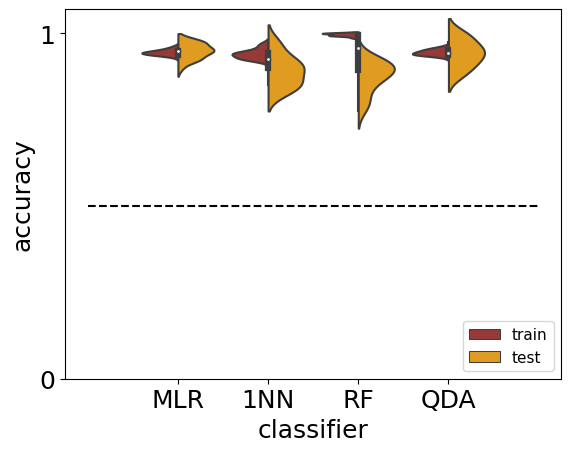

In [12]:
# plot: train versus test accuracy
acc2 = acc[np.logical_or(acc['type']=='train',acc['type']=='test')]

# theoretical chance level
chance_level = 0.5

sb.violinplot(data=acc2, x='clf', y='score', hue='type', split=True, scale='width', palette=['brown','orange']) # cut=0
plt.plot([-1,4], [chance_level]*2, '--k')
plt.yticks([0,1])
plt.xlabel('classifier')
plt.ylabel('accuracy')
plt.legend(loc='lower right', fontsize=11)
plt.show()


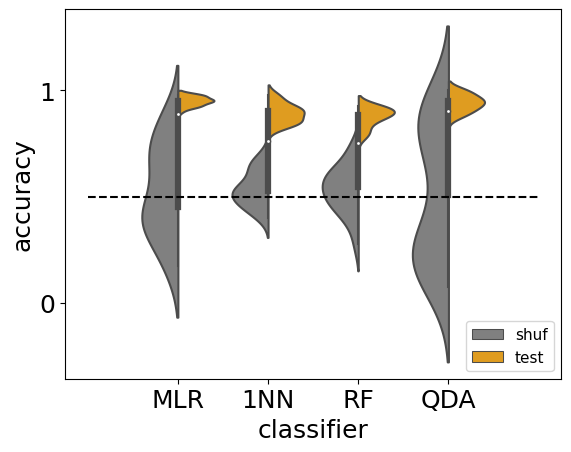

In [13]:
# test versus baseline accuracy
acc2 = acc[np.logical_or(acc['type']=='shuf',acc['type']=='test')]

sb.violinplot(data=acc2, x='clf', y='score', hue='type', hue_order=['shuf','test'], 
              split=True, scale='width', palette=['gray','orange'])
plt.plot([-1,4], [chance_level]*2, '--k')
plt.yticks([0,1])
plt.xlabel('classifier')
plt.ylabel('accuracy')
plt.legend(loc='lower right', fontsize=11)
plt.show()